<a href="https://colab.research.google.com/github/heerboi/AI-from-scratch/blob/main/gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Following Andrej's video: https://www.youtube.com/watch?v=kCc8FmEb1nY

In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt

--2025-09-01 21:25:20--  https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.01s   

2025-09-01 21:25:21 (106 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
with open('input.txt', 'r', encoding="utf-8") as f:
    text = f.read()

In [3]:
text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [5]:
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s, i in stoi.items()}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itos[i] for i in l])

print(encode("Hii"))
print(decode(encode("Hii")))

[20, 47, 47]
Hii


In [6]:
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [7]:
split = int(0.9*len(data))
train_data = data[:split]
val_data = data[split:]
print(len(train_data))
print(len(val_data))

1003854
111540


In [8]:
#context length

block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [9]:
x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(context, target)

tensor([18]) tensor(47)
tensor([18, 47]) tensor(56)
tensor([18, 47, 56]) tensor(57)
tensor([18, 47, 56, 57]) tensor(58)
tensor([18, 47, 56, 57, 58]) tensor(1)
tensor([18, 47, 56, 57, 58,  1]) tensor(15)
tensor([18, 47, 56, 57, 58,  1, 15]) tensor(47)
tensor([18, 47, 56, 57, 58,  1, 15, 47]) tensor(58)


In [10]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [11]:
torch.manual_seed(1337)
batch_size = 4
block_size = 8

def get_batch(split):

    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+1+block_size] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

x, y = get_batch("train")
print(x)
print(y)

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]], device='cuda:0')
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]], device='cuda:0')


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()

        self.token_embedding_table = nn.Embedding(num_embeddings = vocab_size, embedding_dim = vocab_size)

    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape

            logits = logits.view(B*T, C)
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            # last time step for each batch and include all embeddings
            logits = logits[:, -1, :]

            probabilities = F.softmax(logits, dim=1)
            # (B, 1)
            next_idx = torch.multinomial(probabilities, num_samples=1)
            # (B, T+1)
            idx = torch.cat((idx, next_idx), dim=1)
        return idx

m = BigramLanguageModel(vocab_size).to(device)
out, loss = m(x, y)
print(out.shape)
print(out)

print(decode(m.generate(torch.zeros((1,1), dtype=torch.long, device=device), max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor([[ 1.6347, -0.0518,  0.4996,  ...,  0.2432,  1.1519,  0.9950],
        [ 0.3418, -0.9276,  1.2381,  ...,  1.5018, -0.5266,  0.2354],
        [ 0.1479, -0.4333,  0.5203,  ...,  0.3302,  1.5454,  1.3778],
        ...,
        [-0.5693, -0.0735,  0.7743,  ..., -0.0815, -1.1445, -0.0623],
        [ 0.4658, -0.2573, -1.0673,  ...,  1.2439,  1.3471,  1.6910],
        [-0.4553,  0.0139,  0.9309,  ...,  0.0290, -0.7568,  0.8701]],
       device='cuda:0', grad_fn=<ViewBackward0>)

yq$;tfBfROkNdcuwdZZTkOMl;,ertK
w:!PLCkMBbeA$3:XaSGJO-3p&M-c?KL3auhpFYVXJFhNNNuhq$OMxv.tbVFYdXlrFZaAe


In [13]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32

for steps in range(5000):
    xb,yb = get_batch('train')

    logits, loss = m(xb,yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.6424217224121094


In [ ]:
print(decode(m.generate(torch.zeros((1,1), dtype=torch.long, device=device), max_new_tokens=1000)[0].tolist()))


Wawice my.

HDEdaromzy mu 
Yow&$LMuof isth ble mil;KI ll, ath iree sengmin lat HNGEdrovDEs, and Win nghire yWjus!
el lind me l.
lishe ce hiry ptug; aisspllw y.
Hllin's n Bfopetelives
MPOFGll, d mothakleo Windo whthCorib3MI'Tham dourive we hixend t so mower; te

ANk d nterurt f s ar igr Wam:

Enge maleronth,faf Pre?

WISo .
r f-NLLERar,

b&hak
Ardsal thes ghesthiuin cNI ayaraney Iry ts I&fr yES:
Myonge tonok,
I g.
AYor 'Wour me?
I
Tha anghy t-senomes twe meFlrdand s stz;

Whes th llety od,OThomuco ffvomy ssthecas l.
Tu Eias wethaleinju.
se eXJPeABene ovevLKimoCas!



Cos cok hedin tie s ind aus xVOFeRO, aLI:
Whit Clo gscPun?
WYUSis du he n,e, xme achZchitheakwhar
FRDurENINAs m s s withoumas Fond t sNTZlo INour id,ONF'sedInsurADYxI idurd pZ
&XnGinond Ca?
Fy
K:HBIUSHou tiund thornofen e sutan xaprythere whanothavitthers,lepEYBllellk t on s h O, t pr b.
Thwat d&Live Wout ir f; u;qyoeknen ouere 3fano iru fo.

FQS:WoQUEHRnk;G huchen tck is,, h pr t ftanofallon bay ho s, ag

AMe, meseveminds

In [14]:
eval_iters = 200
@torch.no_grad()
def estimate_loss():
    out = {}
    m.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(split)
            logits, loss = m(xb, yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out
estimate_loss()

{'train': tensor(4.6475), 'val': tensor(4.6486)}

## Mathematical trick in self-attention!

- have to average the logits in the time dim 0..t for logit t


In [ ]:
B, T, C = 4, 8, 2
x = torch.randn(B,T,C)

In [ ]:
div = torch.tril(torch.ones(T,T))
div /= div.sum(dim=1, keepdim=True)
xbow = div @ x

In [ ]:
div

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [ ]:
x[0], xbow[0]

(tensor([[ 0.1403, -0.0290],
         [ 0.9005,  0.2836],
         [-0.7107, -0.2802],
         [ 1.4693,  0.6379],
         [-0.3859,  1.4116],
         [-0.6111, -1.1886],
         [-0.4339, -0.0700],
         [-0.1715,  0.5119]]),
 tensor([[ 0.1403, -0.0290],
         [ 0.5204,  0.1273],
         [ 0.1100, -0.0085],
         [ 0.4499,  0.1531],
         [ 0.2827,  0.4048],
         [ 0.1337,  0.1392],
         [ 0.0526,  0.1093],
         [ 0.0246,  0.1597]]))

### using softmax(infinity)

hint: e^-infinity = 0, and e^0 = 1

In [ ]:
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei,dim=1)
xbow3 = wei @ x
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

## A bit about attention

- Attention is just a mechanism that adds a set of values with a set of weights. The approach above takes the weights to be equally distributed for the node itself and the nodes before, and zero for all nodes after.

- But, the current node might find more of what it needs from some nodes rather than others; it won't necessarily be equally distributed.

- Paper proposes an attention function where each node (token) at time T emits a query vector that contains the information that the current node is looking for, and a key vector that contains the information that the current node has within itself.

- This query vector and key vector get multiplied together to get the "affinities" between what the nodes are looking for and what the nodes have (T, T dimension, so each combination)

- Instead of taking the average of each node, we perform softmax on this new matrix. Now, instead of multiplying the "original" values $x$, we multiply it with the "value" matrix, which is different for each attention "head"

- As each head has a different purpose, it will have a different value to emit in each head, a different value that it posesses that makes more sense for that particular head!

In [ ]:
head_size = 16
Q = nn.Linear(C, head_size, bias=False)
K = nn.Linear(C, head_size, bias=False)
V = nn.Linear(C, head_size, bias=False)

queries = Q(x)
keys = K(x)

print(queries.shape)
print(keys.shape)

torch.Size([4, 8, 16])
torch.Size([4, 8, 16])


In [ ]:
T

8

In [ ]:
tril = torch.tril(torch.ones(T, T))
wei = keys @ queries.transpose(-2, -1) # (4, 8, 8)
# wei = torch.zeros((T, T))
wei1 = wei.masked_fill(tril==0, float('-inf'))
wei1 = F.softmax(wei1, dim=1)
wei = F.softmax(wei,dim=1)

values = V(x)

xbow4 = wei @ values
xbow5 = wei1 @ values
print(wei.shape)
print(xbow4.shape)

torch.Size([4, 8, 8])
torch.Size([4, 8, 16])


In [ ]:
wei[0], xbow4[0]

(tensor([[1.3034e-01, 9.7777e-02, 6.5728e-02, 3.8532e-02, 4.6907e-02, 3.3497e-02,
          9.5107e-02, 1.0166e-01],
         [1.3475e-01, 6.9356e-02, 9.2154e-02, 1.7871e-02, 8.8114e-03, 1.3792e-01,
          1.0369e-01, 5.5449e-02],
         [1.2322e-01, 1.2296e-01, 5.1104e-02, 6.9791e-02, 2.9180e-01, 8.2023e-03,
          9.2603e-02, 1.9814e-01],
         [1.3500e-01, 4.4372e-02, 1.3851e-01, 7.2671e-03, 2.3898e-03, 4.9373e-01,
          1.2049e-01, 3.4751e-02],
         [9.2688e-02, 9.1358e-03, 4.3625e-01, 7.5236e-04, 7.1513e-02, 2.4623e-01,
          2.9044e-01, 1.2821e-01],
         [1.4848e-01, 5.2391e-01, 1.5794e-02, 8.1641e-01, 3.5730e-01, 1.7959e-03,
          4.7736e-02, 2.0377e-01],
         [1.2244e-01, 9.3229e-02, 6.5405e-02, 4.0686e-02, 1.5209e-01, 1.6325e-02,
          1.0233e-01, 1.5718e-01],
         [1.1309e-01, 3.9264e-02, 1.3505e-01, 8.6923e-03, 6.9186e-02, 6.2312e-02,
          1.4760e-01, 1.2084e-01]], grad_fn=<SelectBackward0>),
 tensor([[ 4.5081e-02,  4.1569e-02,

In [ ]:
wei1[0], xbow5[0]

(tensor([[1.3034e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.3475e-01, 7.6873e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.2322e-01, 1.3628e-01, 6.0685e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.3500e-01, 4.9181e-02, 1.6448e-01, 8.3167e-03, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [9.2688e-02, 1.0126e-02, 5.1804e-01, 8.6101e-04, 1.1000e-01, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.4848e-01, 5.8069e-01, 1.8755e-02, 9.3431e-01, 5.4962e-01, 2.2328e-02,
          0.0000e+00, 0.0000e+00],
         [1.2244e-01, 1.0333e-01, 7.7668e-02, 4.6562e-02, 2.3395e-01, 2.0296e-01,
          4.0943e-01, 0.0000e+00],
         [1.1309e-01, 4.3520e-02, 1.6037e-01, 9.9476e-03, 1.0643e-01, 7.7471e-01,
          5.9057e-01, 1.0000e+00]], grad_fn=<SelectBackward0>),
 tensor([[ 3.5628e-03,  8.0178e-03,

there's a little problem tho

In [ ]:
query = torch.randn((4, 8, 16))
key = torch.randn((4, 8, 16))

print(query.var())
print(key.var())

tensor(0.9601)
tensor(0.8890)


In [ ]:
qk = key @ query.transpose(-2, -1)
print(qk.var())

tensor(14.1292)


HUGE difference in variance, and when variance is high, means the difference between the values is huge. Since we'll apply softmax on this, if the values are very imbalanced, there'll be a huge imbalance in the weight assigned to other nodes, esp when the network is still untrained.

The paper proposes dividing the multiplication by the square root of head size, let's try it.

In [ ]:
qk = key @ query.transpose(-2, -1) * head_size**-0.5
print(qk.var())

tensor(0.8831)


looks good

In [28]:
# num of attn heads running in parallel
n_heads = 16
# embedding size
# all layer final outputs must match 256
n_embd = 512

# individual heads are concat at the end
head_size = n_embd // n_heads

# size of ffn hidden layer
hidden_size = 1024

# total number of stacked transformer blocks
n_blocks = 6
block_size=12

In [ ]:
def create_thetas(seq_len, n_embd, theta = 10000):

    num = torch.arange(0, n_embd, 2).float()
    thetas = 1.0/theta**(num/n_embd)

    m = torch.arange(0, seq_len)

    freqs = torch.outer(m, thetas).float()

    freqs_complex = torch.polar(torch.ones_like(freqs),freqs)

    return freqs_complex

def apply_rot_embd(x, freqs_complex):

    # all shapes except last; divide last shape into pairs of two
    x = x.float().reshape(*x.shape[:-1], -1, 2)

    x_complex = torch.view_as_complex(x)

    x_complex_rot = x_complex * freqs_complex

    x_rot = torch.view_as_real(x_complex_rot).reshape(*x.shape)

    return x_rot

In [22]:
class SingleAttentionHead(nn.Module):

    def __init__(self, rope_freqs, mask=False):
        super().__init__()
        self.Q = nn.Linear(n_embd, head_size, bias=False)
        self.K = nn.Linear(n_embd, head_size, bias=False)
        self.V = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.rope_freqs = rope_freqs
        # encoder attn module
        self.mask = mask

    def forward(self, x, encoder_embd=None):
        B, T, C = x.shape
        # (B, T, head_size)
        queries = apply_rot_embd(self.Q(x), self.rope_freqs)

        if encoder_embd:
            keys = self.K(encoder_embd)
            values = self.V(encoder_embd)
        else:
            keys = self.K(x)
            values = self.V(x)

        keys = apply_rot_embd(keys, self.rope_freqs)

        wei = keys @ queries.transpose(-2, -1) * head_size ** -0.5
        if self.mask:
            wei = wei.masked_fill(self.tril == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)

        x = wei @ values
        return x

class FFN(nn.Module):

    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.layers = nn.Sequential(
            # op: (B, T, hidden_size)
            nn.Linear(in_features, hidden_size, bias=bias),
            nn.ReLU(),
            # op: (B, T, n_embd)
            nn.Linear(hidden_size, out_features, bias=bias),
            nn.Dropout(p=0.1)
        )
        self.layer_norm=nn.LayerNorm(out_features)

    def forward(self, x):
        out = x + self.layer_norm(self.layers(x))
        return out

In [23]:
class MultiAttentionBlock(nn.Module):

    def __init__(self, mask=False):
        super().__init__()


        rope_freqs = create_thetas(seq_len=block_size, n_embd=n_embd)

        self.heads = [SingleAttentionHead(mask, rope_freqs).to(device) for _ in range(n_heads)]

        self.linear = nn.Linear(n_embd, n_embd)

        self.layer_norm = nn.LayerNorm(n_embd)
        self.dropout=nn.Dropout(p=0.1)

    def forward(self, x, encoder_embd=None):
        # each op: (B, T, head_size)
        act = [head(x, encoder_embd) for head in self.heads]
        # op: (B, T, n_embd)
        out = x+self.layer_norm(self.dropout(self.linear(torch.concat(act, dim=-1))))

        return out

class DecoderBlock(nn.Module):
    def __init__(self, is_enc=False):
        super().__init__()

        self.multi_self_attention_block = MultiAttentionBlock(mask=True).to(device)
        if is_enc:
            self.cross_attn_block = MultiAttentionBlock(mask=False).to(device)
        self.ffn = FFN(n_embd, n_embd).to(device)

    def forward(self, x, encoder_embd=None):
        x = self.multi_self_attention_block(x)
        if encoder_embd:
            x = self.cross_attn_block(x, encoder_embd)
        x = self.ffn(x)

        return x

class EncoderBlock(nn.Module):
    def __init__(self):

        super().__init__()

        self.multi_self_attention_block = MultiAttentionBlock(mask=False).to(device)

        self.ffn = FFN(n_embd, n_embd).to(device)

    def forward(self, x):
        x = self.multi_self_attention_block(x)
        x = self.ffn(x)

        return x

In [24]:
def positional_embed(seq_len, n_embd):
    pe = torch.zeros(seq_len, n_embd, device=device)

    position = torch.arange(0, seq_len).unsqueeze(1).float()
    even = torch.arange(0,n_embd,2).float()

    pe[:, 0::2] = torch.sin(position / 10000**(2*even/n_embd))
    pe[:, 1::2] = torch.cos(position / 10000**((2*even+1)/n_embd))
    return pe

In [33]:
class Transformer(nn.Module):

    def __init__(self, encoder=False):
        super().__init__()
        self.encoder=encoder

        self.token_embedding_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=n_embd)

        # positional embedding applied in the MultiAttentionBlock layer

        # self.rope_freqs = create_thetas(seq_len=block_size, n_embd=n_embd)
        # self.position_embedding_table = positional_embed(block_size, n_embd)
        # self.lm_head = SingleAttentionHead(head_size)
        # self.ffn = FFN(head_size, hidden_size)
        # self.attention_block = SingleAttentionBlock(head_size, hidden_size)

        # inp: (B, T, n_embd)
        # op:  (B, T, n_embd)
        # self.multi_head_attn = MultiAttentionBlock()

        # self.ffn = FFN(n_embd, n_embd)
        # pairs of multi head self attn blocks + ffn in sequence
        if encoder:
            self.encoder_block = nn.Sequential(*[EncoderBlock().to(device) for _ in range(n_blocks)])
        self.decoder_block = nn.Sequential(*[DecoderBlock(is_enc=encoder).to(device) for _ in range(n_blocks)])

        self.nn = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_embd = self.token_embedding_table(idx)
        pos_embd = torch.nn.Dropout(0.1)(self.position_embedding_table)
        x = torch.nn.Dropout(0.1)(tok_embd + pos_embd)
        # x = self.lm_head(x)
        # x = self.ffn(x)
        # x = self.attention_block(x)
        # residual connections moved to their respective classes
        if self.encoder:
            x_enc = self.encoder_block(x)
            x = self.decoder_block(x, x_enc)
        else:
            x = self.decoder_block(x)

        logits = self.nn(x)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape

            logits = logits.view(B*T, C)
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets, label_smoothing=0.1)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # pick only last 8 tokens for next token
            idx_next = idx[:, -block_size:]
            logits, loss = self(idx_next)
            # last time step for each batch and include all embeddings
            logits = logits[:, -1, :]

            probabilities = F.softmax(logits, dim=1)
            # (B, 1)
            next_idx = torch.multinomial(probabilities, num_samples=1)
            # (B, T+1)
            idx = torch.cat((idx, next_idx), dim=1)
        return idx

In [31]:
xb, yb = get_batch('train')

In [34]:
m = Transformer(encoder=False).to(device)
out, loss = m(xb, yb)
print(out.shape)
print(out)
print("Total parameters:")
print(sum([p.nelement() for p in m.parameters()]))

print(decode(m.generate(torch.zeros((1,12), dtype=torch.long, device=device), max_new_tokens=100)[0].tolist()))

torch.Size([48, 65])
tensor([[-4.5443, -0.9509,  0.7587,  ..., -2.8085, -1.6790,  3.3497],
        [-3.9272, -0.8647,  1.5374,  ..., -1.5479, -1.1091,  2.1935],
        [-2.8077,  1.0421,  1.9535,  ..., -1.5259, -0.7239,  1.8795],
        ...,
        [-1.1621, -0.8017, -2.4086,  ..., -1.5229,  0.3033,  1.5330],
        [-1.5756, -1.1124, -2.1812,  ..., -3.2714,  0.8436,  5.2548],
        [-2.8672, -1.6880, -0.1808,  ..., -0.7928, -1.0709,  4.0498]],
       device='cuda:0', grad_fn=<ViewBackward0>)
Total parameters:
7955521












&v:SXvTcCSgShmpxHhe:bhB:c.:S.RvJ&B:cJHxSceHE::.:nZd:QC:Q.cT:SQSb:::HvBcA:H.::lDz!BJHH.::BlhbjRB::.B:


In [ ]:
optimizer = torch.optim.AdamW(m.parameters(), lr=5e-3)

In [ ]:
batch_size = 256

for steps in range(4000):
    xb,yb = get_batch('train')

    logits, loss = m(xb,yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if steps % 100 == 0:
        print(f"Loss at {steps}: {loss.item()}")

Loss at 0: 6.114280700683594
Loss at 100: 2.9559812545776367
Loss at 200: 2.876805305480957
Loss at 300: 2.8559279441833496
Loss at 400: 2.7874696254730225
Loss at 500: 2.7243618965148926
Loss at 600: 2.6580650806427
Loss at 700: 2.6288387775421143
Loss at 800: 2.5366058349609375
Loss at 900: 2.496201753616333
Loss at 1000: 2.4595253467559814
Loss at 1100: 2.426161289215088
Loss at 1200: 2.428075075149536
Loss at 1300: 2.3550968170166016
Loss at 1400: 2.3633785247802734
Loss at 1500: 2.3219783306121826
Loss at 1600: 2.3214876651763916
Loss at 1700: 2.2958872318267822
Loss at 1800: 2.26100492477417
Loss at 1900: 2.2622005939483643
Loss at 2000: 2.269721746444702
Loss at 2100: 2.2326300144195557
Loss at 2200: 2.2713429927825928
Loss at 2300: 2.2348101139068604
Loss at 2400: 2.2033002376556396
Loss at 2500: 2.219783067703247
Loss at 2600: 2.2134768962860107
Loss at 2700: 2.2253730297088623
Loss at 2800: 2.2111055850982666
Loss at 2900: 2.2094995975494385
Loss at 3000: 2.19453763961792
Los

training a bit longer bec loss still decreasing

In [ ]:
batch_size = 512

for steps in range(1500):
    xb,yb = get_batch('train')

    logits, loss = m(xb,yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if steps % 100 == 0:
        print(f"Loss at {steps}: {loss.item()}")

Loss at 0: 2.0496819019317627
Loss at 100: 2.0727758407592773
Loss at 200: 2.073080062866211
Loss at 300: 2.0541653633117676
Loss at 400: 2.079529285430908
Loss at 500: 2.04020619392395
Loss at 600: 2.048889636993408
Loss at 700: 2.0375494956970215
Loss at 800: 2.0214457511901855
Loss at 900: 2.063189744949341
Loss at 1000: 2.0144102573394775
Loss at 1100: 2.0200018882751465
Loss at 1200: 2.026115655899048
Loss at 1300: 2.0526821613311768
Loss at 1400: 2.0687477588653564


In [ ]:
estimate_loss()

{'train': tensor(2.0590), 'val': tensor(2.2176)}

* transformer with single attention block, no layer norm, and no ffn: train 2.3442 val: 2.3719
* transformer with single attn, layer norm and ffn, no residual connection: train 2.2628 val 2.3023

* transformer with multi head attn + linear, layer norm, ffn and residual connection in after multihead attn: train 1.7584 val 1.9072

* transformer with multiple stacked attention-ffn blocks!: train 1.65 val 1.82

* using sinusoidal positional embedding converges much faster!! train 1.71 val 1.87

* GPU MAKES IT SM FASTERRRRRRR but model stops learnign because im doing layernorm after residual?? it works when i do residual after layernorm


new best: train 1.49 val 1.75

In [ ]:
print(decode(m.generate(torch.zeros((1,12), dtype=torch.long,device=device), max_new_tokens=1000)[0].tolist())[16:])

QJ,
XEJSH. 3 n
CAHORD:
;thertax theKing Henry?

BENVOLIO:
Well, yourxelpher be&TIO:
And thzen she displ
For dham;quePVvRTouches:
The prwetch woerful alo;
Ay, this my Kn3THUMARION EWIMKE; not he drops:
Tell thee, I -thank IPut Auffide,
I $ady--
Thing were now the ea!
To hComind thave trable thy!
MercificiousI severs: moreQu:
LiOr God's party.

DUCSTER:
, here his her!
Was I know you no time
ThaR stanUR Polenbury, Pompe!
Comnd thee, tial's limbsDtrotham.IN, this knmcure!
Breen let me soldiers, mercyz$eN suddent3 K!;
Rath ! mi. Serves, I would sMeechAge. YGOBY:
The raling ijur.

O! LArdtay that miss the secvented of one CRICupito be they befLat&
LHe taste Aufid
To; brwoth her childrT
fordner senJwH'd room to Bianca? y! what youW dourF, my fSlympies that a say in theS.

BRUTUS:
My fly,Sly! yotma man! Catesby.

All:
AWereheHear the DuffyQuit Angelo! The proRe noon, give me
From your children, there betts sneigp: the Somerful proceed,
AJULICO:
IDa! , for it.

DUAuIO:
It read
My eyet and 


## positional encoding


In [ ]:
from math import sin, cos

In [ ]:
i = list(range(1,51))
pos = list(range(1,9))
embeddings = {n:[] for n in pos}
embeddings_no_div = {n:[] for n in pos}
for p in pos:
    for num in i:
        if num % 2 == 0:
            embed = sin(p)
            div_embed = sin(p/10000**(-2*num/512))
        else:
            embed = cos(p)
            div_embed = cos(p/10000**(-2*num/512))
        embeddings_no_div[p].append(embed)
        embeddings[p].append(div_embed)

In [ ]:
sin(1)

0.8414709848078965

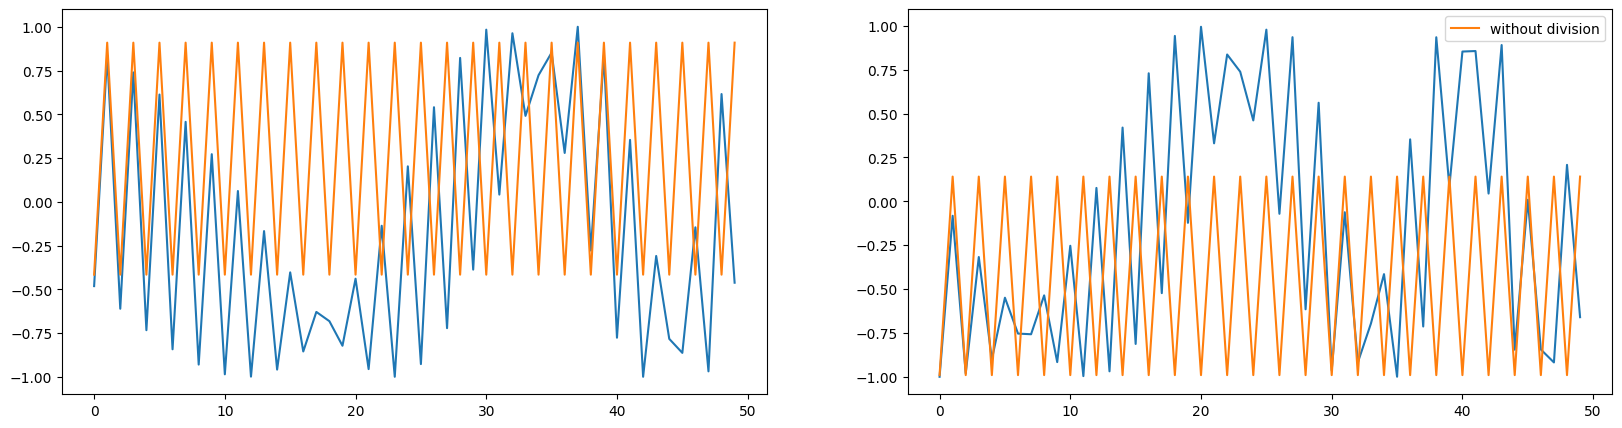

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 5)
ax[0].plot(embeddings[2])
ax[0].plot(embeddings_no_div[2], label = "Without division")
# ax[0].plot(embeddings[6])
ax[1].plot(embeddings[3])
ax[1].plot(embeddings_no_div[3], label = "without division")
# ax[1].plot(embeddings[5])
# plt.plot([e for e in embeddings.values()],label = [f"Pos{i}" for i in embeddings.keys()])
plt.legend()
plt.show()

In [ ]:
xb

tensor([[31, 43, 41, 53, 52, 42,  1, 25],
        [61, 52,  1, 41, 46, 53, 47, 41],
        [ 1, 51, 63,  1, 50, 47, 43, 45],
        [58, 46, 43, 43,  1, 58, 53,  1],
        [44, 47, 56, 43, 12,  0, 17, 42],
        [ 0, 28, 13, 33, 24, 21, 26, 13],
        [43, 47, 60, 43,  5, 57,  1, 47],
        [44, 39, 41, 43,  6,  0, 32, 46],
        [ 1, 60, 47, 53, 50, 43, 52, 58],
        [39, 52, 52, 43, 57, 57,  6,  1],
        [33, 25, 14, 17, 30, 24, 13, 26],
        [ 8,  0, 31, 47, 56,  6,  1, 58],
        [46,  1, 57, 53,  1, 50, 53, 52],
        [59, 58,  1, 52, 53, 58,  1, 41],
        [57, 58,  1, 46, 43,  1, 58, 46],
        [58,  1, 42, 39, 63, 57,  6,  1],
        [45, 43, 58,  1, 58, 46, 43, 43],
        [57, 58, 63,  8,  0,  0, 35, 13],
        [56, 52,  8,  0, 28, 43, 56, 41],
        [39,  1, 40, 50, 53, 61,  8,  0],
        [58,  1, 58, 46, 53, 59,  1, 58],
        [16, 33, 23, 17,  1, 34, 21, 26],
        [59,  1, 46, 53, 51, 43,  1, 58],
        [47, 52, 42,  0, 37, 53, 5

In [ ]:
torch.arange(0, 5).unsqueeze(1).shape

torch.Size([5, 1])

In [ ]:
even = torch.arange(0,n_embd,2).float()
even+1

tensor([  1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,  23.,
         25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,  43.,  45.,  47.,
         49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.,  67.,  69.,  71.,
         73.,  75.,  77.,  79.,  81.,  83.,  85.,  87.,  89.,  91.,  93.,  95.,
         97.,  99., 101., 103., 105., 107., 109., 111., 113., 115., 117., 119.,
        121., 123., 125., 127., 129., 131., 133., 135., 137., 139., 141., 143.,
        145., 147., 149., 151., 153., 155., 157., 159., 161., 163., 165., 167.,
        169., 171., 173., 175., 177., 179., 181., 183., 185., 187., 189., 191.,
        193., 195., 197., 199., 201., 203., 205., 207., 209., 211., 213., 215.,
        217., 219., 221., 223., 225., 227., 229., 231., 233., 235., 237., 239.,
        241., 243., 245., 247., 249., 251., 253., 255.])

In [ ]:
def positional_embed(seq_len, n_embd):
    pe = torch.zeros(seq_len, n_embd)

    position = torch.arange(0, seq_len).unsqueeze(1).float()
    even = torch.arange(0,n_embd,2).float()

    pe[:, 0::2] = torch.sin(position / 10000**(2*even/n_embd))
    pe[:, 1::2] = torch.cos(position / 10000**((2*even+1)/n_embd))
    return pe

In [ ]:
positional_embed(8,8)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  9.5042e-01,  9.9998e-03,  9.9999e-01,  1.0000e-04,
          1.0000e+00,  1.0000e-06,  1.0000e+00],
        [ 9.0930e-01,  8.0658e-01,  1.9999e-02,  9.9998e-01,  2.0000e-04,
          1.0000e+00,  2.0000e-06,  1.0000e+00],
        [ 1.4112e-01,  5.8275e-01,  2.9995e-02,  9.9995e-01,  3.0000e-04,
          1.0000e+00,  3.0000e-06,  1.0000e+00],
        [-7.5680e-01,  3.0114e-01,  3.9989e-02,  9.9992e-01,  4.0000e-04,
          1.0000e+00,  4.0000e-06,  1.0000e+00],
        [-9.5892e-01, -1.0342e-02,  4.9979e-02,  9.9988e-01,  5.0000e-04,
          1.0000e+00,  5.0000e-06,  1.0000e+00],
        [-2.7942e-01, -3.2080e-01,  5.9964e-02,  9.9982e-01,  6.0000e-04,
          1.0000e+00,  6.0000e-06,  1.0000e+00],
        [ 6.5699e-01, -5.9944e-01,  6.9943e-02,  9.9976e-01,  7.0000e-04,
          1.0000e+00,  7.0000e-06,  1.0000e+00]])